In [1]:

#Data Cleansing part 1
import codecs
import math
import re
import os
import time
#import string
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from nltk import FreqDist
from nltk.corpus import stopwords
#from spacy.lemmatizer import Lemmatizer as lemma
#from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
#from nltk.tokenize import word_tokenize

start = time.time()

script_dir = os.path.dirname(os.path.realpath('__file__')) #<-- absolute dir the script is in
rel_path = "../02_data/" ; abs_file_path = os.path.join(script_dir, rel_path)

Files = ["wallstreet.csv", "winter.csv", "christmas.csv", "britishcricket.csv", "scubadive.csv", "brexit.csv" ];
out = ["allwallstreet.txt","allwinter.txt", "allchristmas.txt", "allbritishcricket.txt", "allscubadive.txt", "allbrexit.txt" ]; ind = -1

cleaned_tweets = defaultdict(list); all_hashtags = defaultdict(list)
stop_words = set(stopwords.words('english'))

for file in Files: 
    ind += 1
    outfile = os.path.join(abs_file_path, out[ind])
    with codecs.open(outfile, "w", "utf-8") as out_data:
        
        readfile = os.path.join(abs_file_path, file)
        #print(readfile)
        with open(readfile, "r", encoding = "utf8") as my_input_file:
            
            for line in my_input_file:
                # clean data
                line = re.sub("`|@|,|~|\n|'['|']'|'?'|<.*>|<|!|\.|\$|\*|:|%|\+|…|\\\\|\/|«|»|···|\||\•|\?|\(|\)|=|-|&|;|\_|—|~|¯|\{|\}|\[|\]|£|€|¥|¿|–|\“|\”|\‘|\’|\"|,|'", " ", line)
                line = re.sub("http[a-zA-Z0-9]+", "", line)
                line = re.sub("pictwitter"," pictwitter", line); line = re.sub(" # "," #", line); line = re.sub("#"," #", line); line = re.sub("# ","", line); 
                line = line.lower(); 

                # remove stop words
                word_list = line.split(' ');  filt_words = []
                for word in word_list:
                    if ((word not in stop_words) and (word != '' and len(word)>2) and (not word.__contains__('pictwitter'))):
                        filt_words.append(re.sub("  "," ", word)); 
                        if (word[0] == '#') and (len(word)> 1) : all_hashtags[ind].append(word); 

                filt_tweet = ' '.join(filt_words); 
                cleaned_tweets[ind].append(filt_tweet)
                out_data.write(filt_tweet+'\n')

print("Checkpoint 1 completed in ", time.time() - start)


Checkpoint 1 completed in  10.353055715560913


In [2]:
#Data Cleansing part 2
start = time.time()
top_hashtags = []

for tag in all_hashtags.keys():
    hashtag = FreqDist(all_hashtags[tag]).most_common(1)[0][0]
    top_hashtags.append(hashtag)
    
selectedtweets = ["wallstreet.txt","winter.txt", "christmas.txt", "cricket.txt", "scubadive.txt", "brexit.txt" ]; ind = -1
hashtag_file = os.path.join(abs_file_path, "classes.txt")

#Top hashtags in each catagory
with codecs.open(hashtag_file, "w", "utf-8") as hashfile:
    for tag in top_hashtags:
        hashfile.write(tag + '\n')

for file in out:
    ind += 1
    
    readfile = os.path.join(abs_file_path, out[ind])
    with codecs.open(readfile, "r", "utf-8") as read_file:
        
        writefile = os.path.join(abs_file_path, selectedtweets[ind])
        with codecs.open(writefile, "w", "utf-8") as write_file:
            for line in read_file:
                if any(s in line for s in top_hashtags):
                    write_file.write(line)

print("Checkpoint 2 completed in ", time.time() - start);

Checkpoint 2 completed in  2.1458587646484375


In [3]:
#Data segregation
start = time.time();

tweets = selectedtweets; hashtags = top_hashtags;

# Dict = {Hashtag: Tweets} and bag of words
HT = dict.fromkeys(hashtags,''); 
trainHT = defaultdict(list);  testHT = defaultdict(list);
ind = -1; bow = set(); #hashtweets = defaultdict(list);

for file in tweets: 
    
    ind += 1
    infile = os.path.join(abs_file_path, file)
    with codecs.open(infile, "r", "utf-8") as in_data:
        for line in in_data:
            
            for tag in hashtags:
                if tag in line:
                    flag = np.random.choice([0, 1], 1, p=[0.75, 0.25])
                    if flag == 1:
                        #Test data: Dict = {Hashtag: Tweets}
                        line = " ".join(filter(lambda x:x[0]!='#', line.split()))
                        testHT[tag].append(line)
                    else: 
                        # Train set: Dict = {Hashtag: Tweets}
                        trainHT[tag].append(re.sub('#' , '', line)) # {Hashtag: [T1, T2, T3]}
                        HT[tag] += re.sub('#' , '', line) # {Hashtag: ['T1 T2 T3']}

print("Checkpoint 3 completed in ", time.time() - start);

Checkpoint 3 completed in  137.91480207443237


In [38]:

#TF-IDF Section
start = time.time();                    

#Bag of words
#1 creation
for txt in HT.values():
    bow = set(bow).union(set(txt.split(' ')))
#2 Bag of words initialization 
bowDict = {}
for h in HT.keys():
    bowDict[h] = dict.fromkeys(bow, 0)
    #3 Bow updation for each class(hashtag)
    for w in HT[h].split(' ') :
        bowDict[h][w] += 1

#Compute Term-Frequency
def computeTF(bowDict, tweet):
    tfDict = {}
    tweetlen = len(tweet.split(' '))
    for word, count in bowDict.items():
        tfDict[word] = count/float(tweetlen)
    return tfDict

tf = {}
for h, t in HT.items():
    tf[h] = computeTF(bowDict[h], t)

#Compute Inverse document frequency
def computeIDF(docList):
    idfDict = {}
    N = len(docList)
    idfDict = HT.fromkeys(docList[0].keys(), 0)
    for doc in docList: #Each class(hashtag)
        for word, val in doc.items():
            if val > 0:
                if word not in idfDict.keys():
                    idfDict[word] = 1
                else :
                    idfDict[word] += 1

    for word, val in idfDict.items():
        idfDict[word] = math.log10(N / float(val))

    return idfDict

idfs = computeIDF([bowDict[h] for h in bowDict.keys()])

#Compute TF-IDF
def computeTFIDF(tfhashtxt, idfs):
    tfidf = {}
    for word, val in tfhashtxt.items():
        tfidf[word] = val*idfs[word]
    return tfidf

tfidfBow = {}; topfivewords = {}
for hashtag in HT.keys():
    tfidfBow[hashtag] = computeTFIDF(tf[hashtag], idfs)
    topfivewords[hashtag] = dict(Counter(tfidfBow[hashtag]).most_common(5))

tfidf = {}
for hashtag, rankwords in topfivewords.items():
    tfidf[hashtag] = rankwords.keys()
        
tfidfpd = pd.DataFrame.from_dict(tfidf, orient='index')
print(pd.DataFrame(tfidf, columns = ["rank 1", "rank 2", "rank 3", "rank 4", "rank 5"], index = ['#wallstreet', '#winter', '#christmas', '#cricket', '#scubadive', '#brexit' ]))

#print(tfidfpd)
print("Checkpoint 4 completed in ", time.time() - start)
    

            rank 1 rank 2 rank 3 rank 4 rank 5
#wallstreet    NaN    NaN    NaN    NaN    NaN
#winter        NaN    NaN    NaN    NaN    NaN
#christmas     NaN    NaN    NaN    NaN    NaN
#cricket       NaN    NaN    NaN    NaN    NaN
#scubadive     NaN    NaN    NaN    NaN    NaN
#brexit        NaN    NaN    NaN    NaN    NaN
Checkpoint 4 completed in  2.4136130809783936


In [24]:
#Vectors set
start = time.time();         

"""To transform train and test dataset into input and output vectors 
for the multiclass-logistic regression."""

rank = tfidfpd; 
trainXY = pd.DataFrame.from_dict(trainHT, orient='index')
testXY = pd.DataFrame.from_dict(testHT, orient='index')

bow = set()
for i in range(0, len(rank)):
    rankwords = rank.iloc[i]
    bow = set(bow).union(set(rankwords))

#Train data X Y
start_time = time.time()
X = list(bow); Y = list(rank.index.get_values())
r, c = trainXY.shape
train = {}; train[tuple([0]*len(X))] = 0

start_time = time.time()
for i in range(r):
    outY = i

    for j in range(c):
        if trainXY.iloc[i, j] != None :
            inX = [0]*len(X)

            for feature in X:
                if feature in trainXY.iloc[i, j]:
                    inX[X.index(feature)] = 1
                    if tuple(inX) not in train:
                        train[tuple(inX)] = outY
        else : 
            break    

trainpd = pd.DataFrame.from_dict(train, orient='index')

elapsed_time = time.time() - start_time
print('Train data created',elapsed_time)

#Test data X Y
X = list(bow); Y = list(rank.index.get_values())
r, c = testXY.shape
test = {}; test[tuple([0]*len(X))] = 0

start_time = time.time()
for i in range(r):
    outY = i

    for j in range(c):
        if testXY.iloc[i, j] != None :
            inX = [0]*len(X)

            for feature in X:
                if feature in testXY.iloc[i, j]:
                    inX[X.index(feature)] = 1
                    if tuple(inX) not in test:
                        test[tuple(inX)] = outY
        else : 
            break  
                
testpd = pd.DataFrame.from_dict(test, orient='index')

elapsed_time = time.time() - start_time
print('Test data created',elapsed_time)       

print("Checkpoint 5 completed in ", time.time() - start); print("Vector set created --> Success!!!");

Train data created 22.15629482269287
Test data created 7.194382905960083
Checkpoint 5 completed in  33.5862250328064
Vector set created --> Success!!!


In [25]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

#Logistic regression
start = time.time();  

#Train data
train = trainpd
trainX = np.array(list(train.index.get_values()))
trainY = []
for j in range(len(train)):
    trainY.append(list(train.iloc[j])[0])
trainY = np.array(trainY)

#Test data
test = testpd
testX = np.array(list(test.index.get_values()))
testY = []
for j in range(len(test)):
    testY.append(list(test.iloc[j])[0])
testY = np.array(testY)

#Logistic regression.
logreg = LogisticRegression( C=1e1, solver='lbfgs', multi_class='multinomial', max_iter = 3000)

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(trainX, trainY)
PredY = logreg.predict(testX)

accuracy = accuracy_score(testY, PredY)
print('Accuracy: ', accuracy)

#print(confusion_matrix(testY, PredY))
precision, recall, fscore, support = score(testY, PredY)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

print("Checkpoint 6 completed in ", time.time() - start);  print("Task complete -- > Success!!!");

Accuracy:  0.6037735849056604
precision: [0.69565217 0.         0.         0.73333333 1.         1.        ]
recall: [0.88888889 0.         0.         0.84615385 0.8        0.07692308]
fscore: [0.7804878  0.         0.         0.78571429 0.88888889 0.14285714]
support: [18  1  3 13  5 13]
Checkpoint 6 completed in  0.10294175148010254
Task complete -- > Success!!!


c:\program files (x86)\python\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


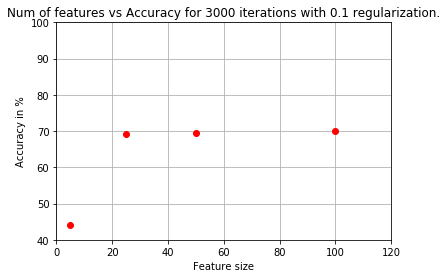

In [26]:
import matplotlib.pyplot as plt
Featuresize = [5, 25, 50, 100]
Accuracy = [44.11, 69.32, 69.45, 69.91]

plt.plot(Featuresize, Accuracy, 'ro')
plt.axis([0, 120, 40, 100])
plt.grid(True)
plt.title('Num of features vs Accuracy for 3000 iterations with 0.1 regularization.')
plt.xlabel('Feature size')
plt.ylabel('Accuracy in %')
plt.savefig('FvsA.png', bbox_inches='tight')


In [27]:
# Confusion matrix
mat = confusion_matrix(testY, PredY)
pd.DataFrame(mat, columns=["wallstreet","winter", "christmas", "cricket", "scubadive", "brexit" ], index = ["wallstreet","winter", "christmas", "cricket", "scubadive", "brexit" ])

,wallstreet,winter,christmas,cricket,scubadive,brexit
wallstreet,16,2,0,0,0,0
winter,1,0,0,0,0,0
christmas,2,1,0,0,0,0
cricket,2,0,0,11,0,0
scubadive,0,0,0,1,4,0
brexit,2,7,0,3,0,1


In [28]:
# Performance metric
score = [list(precision), list(recall), list(fscore), list(support)]; rows = ['precision', 'recall', 'fscore', 'support'];
pd.DataFrame(score,columns=["wallstreet","winter", "christmas", "cricket", "scubadive", "brexit"], index = ['precision', 'recall', 'fscore', 'support'] )

,wallstreet,winter,christmas,cricket,scubadive,brexit
precision,0.695652,0.0,0.0,0.733333,1.000000,1.000000
recall,0.888889,0.0,0.0,0.846154,0.800000,0.076923
fscore,0.780488,0.0,0.0,0.785714,0.888889,0.142857
support,18.000000,1.0,3.0,13.000000,5.000000,13.000000


In [29]:
#TF-IDF top rank words
#print(tfidfpd) # <--uncomment
pd.DataFrame(tfidfpd, columns= ['rank 1', 'rank 2', 'rank 3', 'rank 4', 'rank 5'], index = ["#wallstreet", "#winter", "#christmas", "#cricket", "#scubadive", "#brexit" ])


,rank 1,rank 2,rank 3,rank 4,rank 5
#wallstreet,NaN,NaN,NaN,NaN,NaN
#winter,NaN,NaN,NaN,NaN,NaN
#christmas,NaN,NaN,NaN,NaN,NaN
#cricket,NaN,NaN,NaN,NaN,NaN
#scubadive,NaN,NaN,NaN,NaN,NaN
#brexit,NaN,NaN,NaN,NaN,NaN


In [30]:
print(tfidfpd)

                      0            1                2             3  \
#wallstreet  wallstreet   joinupdots              nyc     dreamlife   
#winter       transfers    minibuses  heathrowshuttle          cabs   
#christmas       pastry   pastrychef         cakeshop         pembs   
#cricket        cricket        f7fy2           string  constitution   
#scubadive    scubadive  scubadiving            scuba          dive   
#brexit      referendum  peoplesvote           labour          tory   

                       4  
#wallstreet  newyorkcity  
#winter          coaches  
#christmas   thecakeshop  
#cricket             dld  
#scubadive    scubadiver  
#brexit              mps  


In [39]:
pd.DataFrame(tfidf, columns = ["rank 1", "rank 2", "rank 3", "rank 4", "rank 5"], index = ['#wallstreet', '#winter', '#christmas', '#cricket', '#scubadive', '#brexit' ])

,rank 1,rank 2,rank 3,rank 4,rank 5
#wallstreet,NaN,NaN,NaN,NaN,NaN
#winter,NaN,NaN,NaN,NaN,NaN
#christmas,NaN,NaN,NaN,NaN,NaN
#cricket,NaN,NaN,NaN,NaN,NaN
#scubadive,NaN,NaN,NaN,NaN,NaN
#brexit,NaN,NaN,NaN,NaN,NaN
